# <center> Matrix factorization </center>

In [51]:
import numpy as np 
import pandas as pd 
import random
import scipy.sparse as sp
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt

## Data preparation

In [52]:

### import the data and create matrix R
data = pd.read_csv('ratings.csv')
data = data.astype({'userId':'int','movieId':'int'})
data = data[['userId','movieId','rating']]
R = data.pivot(index='userId', columns = 'movieId', values = 'rating')
R = R.fillna(0)
R = R.values

## 1- split to train test set 
def create_train_test(ratings):
    """
    split into training and test sets,
    remove 15 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_index = np.random.choice(
            np.flatnonzero(ratings[user]), size = 15, replace = False)
        train[user, test_index] = 0.0
        test[user, test_index] = ratings[user, test_index]
        
    # assert that training and testing set are truly disjoint
    assert np.all(train * test == 0)
    return train, test

train, test = create_train_test(R) ## split to train test
I_train = train!= 0 #mask for train set
I_test = test!= 0    ##mask for test set

In [4]:
np.sum(I_train) ## number of examples in train

91686

In [16]:
np.sum(I_test) ## number of examples in test 

9150

In [17]:
print('The percentage of test set is',np.round(100*np.sum(I_test)/np.sum(I_train),2),'%') ## proportion test with respect to train

The percentage of test set is 9.98 %


## Data Exploration 

In [18]:
print('Number of users is ', R.shape[0],'and the number of movies is', R.shape[1])

Number of users is  610 and the number of movies is 9724


In [19]:
print('The Sparsity of the matrix R is',np.round((np.sum(R==0)/(R.shape[0]*R.shape[1]))*100,2),'%')

The Sparsity of the matrix R is 98.3 %


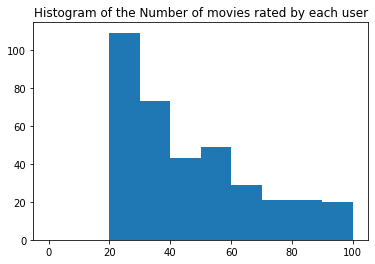

In [20]:
plt.hist((R!=0).sum(axis=1),range =(0,100))
plt.title('Histogram of the Number of movies rated by each user')
plt.show()

The minimum rated movies per user is 2O according to the histogram

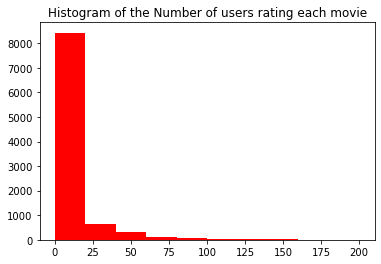

In [21]:
plt.hist((R!=0).sum(axis=0),range =(0,200),color='r')
plt.title('Histogram of the Number of users rating each movie')
plt.show()

A big majority of the movies have less than 25 rating

## 1- svd (singular value decomposition)

In the following cell we implement svd for different values of the dimension k and compute train error and test error for each one

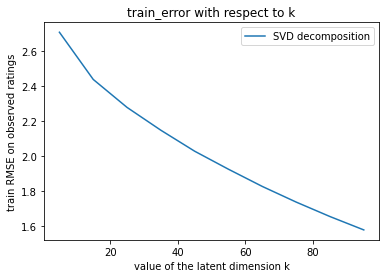

In [23]:
K = np.arange(5,100,10)
error_train = []
error_test = []
for k in K:
    U,S,VT = svds(train, k)
    S_diagonal = np.diag(S)
    Y_hat = np.dot(np.dot(U,S_diagonal),VT)
    rmse_train = np.linalg.norm(I_train*(train-Y_hat))/np.sqrt(np.sum(I_train))
    error_train = error_train + [rmse_train]
    rmse_test = np.linalg.norm(I_test*(test-Y_hat))/np.sqrt(np.sum(I_test))
    error_test+=[rmse_test]
plt.plot(K,error_train, label='SVD decomposition')
plt.xlabel('value of the latent dimension k')
plt.ylabel('train RMSE on observed ratings')
plt.title("train_error with respect to k")
plt.legend()
plt.show()


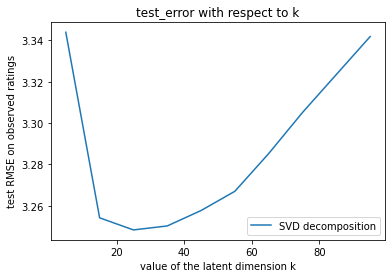

In [24]:
plt.plot(K,error_test,label='SVD decomposition')
plt.xlabel('value of the latent dimension k')
plt.ylabel('test RMSE on observed ratings')
plt.title("test_error with respect to k")
plt.legend()
plt.show()


In [25]:
k = np.argmin(np.array(error_test))

In [28]:
print('the minimum test rmse is given for k equals to', K[k],'It yields for the test rmse' , np.array(error_test)[k],'and for the train rmse', np.array(error_train)[k])

the minimum test rmse is given for k equals to 25 It yields for the test rmse 3.2483546516600486 and for the train rmse 2.277436536927652


## 2- ALS (alternating least squares)

In [53]:
## This function implements ALS training and also returns the prediction,
#the list of train errors and the list of test errors for each time step
## It plots them too

def ALS(k,lamda,mu,niter):
    test_rmse = []
    train_rmse = []  
    U =  np.random.randn(610,k)
    V = np.random.randn(9724,k)

    for i in range(niter):
        prediction = np.dot(U,V.T)
        train_rmse = train_rmse + [np.linalg.norm(I_train*(train-prediction))/np.sqrt(np.sum(I_train))]
        test_rmse = test_rmse + [np.linalg.norm(I_test*(test-prediction))/np.sqrt(np.sum(I_test))]
        m1 = np.dot(V.T,V)+lamda*np.identity(k)
        solve_m1 = np.linalg.inv(m1)
        U = np.dot(train,np.dot(V,solve_m1))
        m2 = np.dot(U.T,U) + mu*np.identity(k)
        solve_m2 = np.linalg.inv(m2)
        V = np.dot(train.T,np.dot(U,solve_m2))
        if i%10==0:
            print('train_rmse',train_rmse[i])
            print('test_rmse',test_rmse[i])

    plt.plot(train_rmse,label='train')
    plt.plot(test_rmse,label='test')
    plt.legend(loc="upper right")
    return(prediction, train_rmse, test_rmse)


train_rmse 7.202968425979925
test_rmse 7.343102205563655
train_rmse 2.113677111377676
test_rmse 3.266166220808307
train_rmse 2.1017722862844757
test_rmse 3.2622028972440784
train_rmse 2.097117255014801
test_rmse 3.2605186253130305
train_rmse 2.0945748231297356
test_rmse 3.259031304936272
train_rmse 2.0929516690485337
test_rmse 3.2578256102173944
train_rmse 2.091852881314509
test_rmse 3.2569376664307828
train_rmse 2.0910746815638817
test_rmse 3.256282362416564
train_rmse 2.0904997841718744
test_rmse 3.2557823743470604
train_rmse 2.0900592021201705
test_rmse 3.2553865122944985


(array([[ 3.06909272e+00,  1.11747935e+00,  7.17832585e-01, ...,
         -1.48722163e-02, -1.48722163e-02, -5.75152994e-02],
        [ 2.41878461e-01, -4.93980886e-02, -4.15160232e-02, ...,
          6.15486371e-03,  6.15486371e-03,  1.12251938e-02],
        [-8.76808648e-03,  2.02006465e-02,  1.45692346e-02, ...,
          2.02869818e-04,  2.02869818e-04, -1.52274288e-03],
        ...,
        [ 1.98360999e+00,  2.54985810e+00,  2.72596137e+00, ...,
         -2.66860544e-03, -2.66860544e-03, -1.72566347e-02],
        [ 3.16460475e-01,  3.84929872e-01,  2.23027834e-01, ...,
          2.82920519e-04,  2.82920519e-04,  1.60251236e-03],
        [ 5.65702285e+00,  4.52922249e-02, -2.95316495e-01, ...,
          9.93269746e-05,  9.93269746e-05,  3.68771002e-02]]),
 [7.202968425979925,
  2.7080798883756048,
  2.2282114441676666,
  2.1687751450556036,
  2.1462394862010683,
  2.134580140285487,
  2.127467872661546,
  2.1225669351743695,
  2.1189083687236,
  2.116029503151804,
  2.113677111377

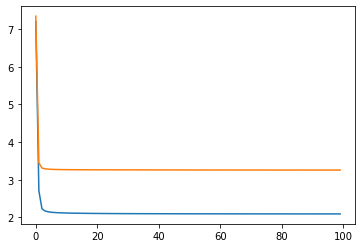

In [35]:
ALS(k=40, lamda=0.01, mu=0.01, niter=100)

ALS converges rapidly but the error on test set is still not small enough

## 3- Gradient descent

In [54]:
## This function implements Gradient descent training and also returns the prediction,
#the list of train errors and the list of test errors for each time step
## It plots them too
def Gradient_descent(k,lamda,mu,niter,tau,I_train,I_test,train):
    test_rmse = []
    train_rmse = []  
    U =  np.random.randn(610,k)
    V = np.random.randn(9724,k)

    for i in range(niter):
        prediction = np.dot(U,V.T)
        train_rmse = train_rmse + [np.linalg.norm(I_train*(train-prediction))/np.sqrt(np.sum(I_train))]
        test_rmse = test_rmse + [np.linalg.norm(I_test*(test-prediction))/np.sqrt(np.sum(I_test))]
        rmse = np.linalg.norm((train-prediction))
        U = U-tau*(np.dot(-2*train,V)+np.dot(2*U,np.dot(V.T,V))+2*lamda*U)

        V = V-tau*(np.dot(-2*train.T,U)+np.dot(2*V,np.dot(U.T,U))+2*mu*V)
#         if i%10==0:
#             print('train_rmse',train_rmse[i])
#             print('test_rmse',test_rmse[i])
    plt.plot(train_rmse)
    plt.plot(test_rmse)
    return(prediction, train_rmse, test_rmse)
            

([7.31715773336893,
  6.398544734719365,
  4.52474973669841,
  3.818215325785834,
  3.6714762381081085,
  3.632178090088413,
  3.6262681421602143,
  3.6237341040146496,
  3.623514778143189,
  3.6232598173042088,
  3.62320850564548,
  3.623135388983805,
  3.6230768667845146,
  3.623018151499847,
  3.6229571896555135,
  3.6228973953294403,
  3.6228353422815713,
  3.622773420025352,
  3.622710027701848,
  3.622646132643172,
  3.6225811329316295,
  3.6225153597479056,
  3.622448600767515,
  3.6223809552486994,
  3.6223123453587056,
  3.6222427925187084,
  3.6221722623987804,
  3.6221007512665895,
  3.622028238147711,
  3.6219547111941153,
  3.621880153203209,
  3.621804549532618,
  3.621727883780409,
  3.621650140127208,
  3.621571302061408,
  3.6214913530626243,
  3.621410276227501,
  3.6213280544652844,
  3.6212446703870227,
  3.621160106359034,
  3.6210743444683646,
  3.6209873665351924,
  3.6208991541001074,
  3.620809688424693,
  3.6207189504849584,
  3.620626920968478,
  3.6205335802

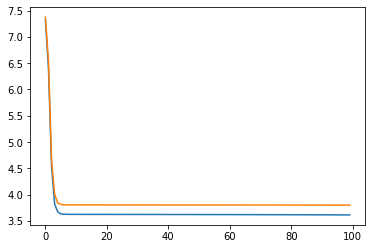

In [56]:
Gradient_descent(40,1,1,100,0.0001,I_train,I_test,train)

## 4 - Probabilistic matrix factorization

In [55]:
## This function implements probabilistic matrix factorization training and also returns the prediction,
#the list of train errors and the list of test errors for each time step
## It plots them too
def PMF(n_iter,lambda_U, labmda_V, n_dims):
    n_users = 610
    n_movies = 9724
    log_aps = []
    train_rmse = []
    test_rmse = [] 
    U = np.zeros((n_dims, n_users), dtype=np.float64)
    V = np.random.normal(0.0, 1.0 / lambda_V, (n_dims, n_movies))
    
    for k in range(n_iter):
        prediction = np.dot(U.T,V)
        train_rmse = train_rmse + [np.linalg.norm(I_train*(train-prediction))/np.sqrt(np.sum(I_train))]
        test_rmse = test_rmse + [np.linalg.norm(I_test*(test-prediction))/np.sqrt(np.sum(I_test))]
        for i in range(n_users):
            V_j = V[:, train[i, :] > 0]
            U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * np.identity(n_dims)), np.dot(train[i, train[i, :] > 0], V_j.T))
        for j in range(n_movies):
            U_i = U[:, train[:, j] > 0]
            V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * np.identity(n_dims)), np.dot(train[train[:, j] > 0, j], U_i.T))
    plt.plot(train_rmse,label='train rmse')
    plt.plot(test_rmse,label='test rmse')
    plt.xlabel('number of iterations')
    plt.legend()
    plt.show()
    return prediction, train_rmse, test_rmse

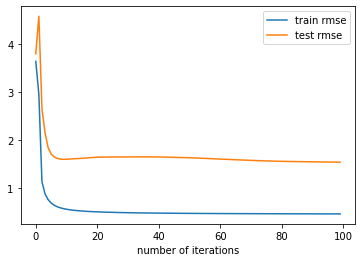

(array([[ 4.70971882,  4.02896671,  3.37299923, ...,  1.74270794,
          1.74270794,  1.48540173],
        [ 3.68526089,  3.01985805,  3.0523533 , ...,  0.17562095,
          0.17562095,  0.05686019],
        [ 0.58939466,  0.71869608, -0.22906858, ...,  2.03906678,
          2.03906678,  0.8121254 ],
        ...,
        [ 3.620248  ,  2.47909443,  2.40387037, ...,  1.05302414,
          1.05302414,  0.74444179],
        [ 3.56771713,  3.35317043,  3.57157881, ...,  0.56701774,
          0.56701774, -0.32653803],
        [ 4.10747576,  3.69832026,  2.66406911, ...,  2.56215534,
          2.56215534,  2.2999223 ]]),
 [3.6388708288085456,
  2.947890085060924,
  1.1311118082876541,
  0.880047502205749,
  0.7592156620314722,
  0.6877972811864381,
  0.6413368126092608,
  0.6098813221094105,
  0.587511463431661,
  0.5708925796760941,
  0.5581058756051356,
  0.5479142415320686,
  0.5395591730937197,
  0.5325529663992359,
  0.5265825984841681,
  0.5214494521778289,
  0.5169935047780839,
  

In [76]:
n_dims = 10
lambda_U = 0.1
lambda_V = 0.1
n_iter = 100
PMF(n_iter,lambda_U, lambda_V, n_dims)

## 5 Let's compare between PMF, GD AND ALS 

    we set first the hyperparameters for each, then we execute the algos 

train_rmse 4.766383596979119
test_rmse 4.908779604331659
train_rmse 2.5539061200262303
test_rmse 3.2710933672112046
train_rmse 2.55075695099002
test_rmse 3.2696412008238496
train_rmse 2.549409454263274
test_rmse 3.268783555940273
train_rmse 2.54864862761669
test_rmse 3.2683070087224713
train_rmse 2.5481584454599275
test_rmse 3.2680178714166055
train_rmse 2.5478085167627555
test_rmse 3.267818939077477
train_rmse 2.547541658657409
test_rmse 3.2676694722079453
train_rmse 2.547329780307348
test_rmse 3.2675512443516754
train_rmse 2.5471571479551147
test_rmse 3.267454878173634


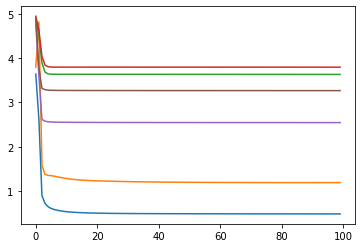

In [37]:
n_dims = 10 
lambda_U = 1
lambda_V = 1
n_iter = 100
k = 10
tau = 0.0001
lamda = 1
mu = 1
prediction_PMF, train_rmse_PMF , test_rmse_PMF = PMF(n_iter,lambda_U, lambda_V, n_dims)
prediction_GD, train_rmse_GD , test_rmse_GD = Gradient_descent(k,lamda,mu,n_iter,tau,I_train,I_test,train)
prediction_ALS, train_rmse_ALS , test_rmse_ALS = ALS(k,lamda,mu,n_iter)


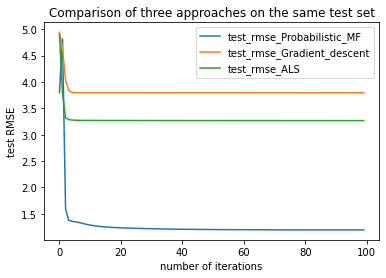

In [38]:
plt.plot(test_rmse_PMF, label = 'test_rmse_Probabilistic_MF')
plt.plot(test_rmse_GD, label = 'test_rmse_Gradient_descent')
plt.plot(test_rmse_ALS, label = 'test_rmse_ALS')
plt.xlabel('number of iterations')
plt.ylabel('test RMSE')
plt.legend()
plt.title('Comparison of three approaches on the same test set')
plt.show()

    The PMF has a lower test error than ALS, the worst is GD

    We visualize some predictions and compare them visually to the real values 

In [59]:
prediction_PMF[[2,5,20,24]]

array([[1.74772325, 1.68604086, 1.89579241, ..., 1.08183412, 1.08183412,
        0.62645178],
       [5.09081823, 4.47125549, 4.03205866, ..., 0.53525261, 0.53525261,
        0.64687705],
       [3.05436681, 3.24278903, 3.37098616, ..., 0.65426624, 0.65426624,
        0.88942636],
       [4.5462829 , 3.57503704, 3.91140546, ..., 1.55158442, 1.55158442,
        2.70380564]])

In [61]:
prediction_GD[[2,5,20,24]]

array([[ 0.00576979,  0.000528  ,  0.00350959, ...,  0.0052753 ,
        -0.00398581,  0.00248379],
       [-0.00493135,  0.01266189, -0.03057415, ...,  0.0013922 ,
        -0.00570357, -0.04229483],
       [-0.01291134,  0.04352381,  0.00938252, ..., -0.00143811,
         0.00202153, -0.00515305],
       [-0.00200537,  0.00115586,  0.00124574, ...,  0.006998  ,
        -0.00010003,  0.0018073 ]])

In [62]:
prediction_ALS[[2,5,20,24]]

array([[ 8.47812529e-04,  4.03386337e-03,  6.68255876e-03, ...,
        -4.16531121e-06, -4.16531121e-06, -1.12558134e-03],
       [ 3.26879112e+00,  3.70451732e+00,  1.89387296e+00, ...,
         2.64127148e-04,  2.64127148e-04, -1.88474966e-02],
       [ 3.00806903e+00,  2.31655273e+00, -1.28863381e-01, ...,
         3.46518770e-02,  3.46518770e-02,  5.18844417e-03],
       [ 2.52474261e-01,  8.48316874e-02, -4.92613055e-02, ...,
         2.62605523e-03,  2.62605523e-03,  3.67610514e-03]])

In [60]:
R[[2,5,20,24]]

array([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
       [0. , 4. , 5. , ..., 0. , 0. , 0. ],
       [3.5, 3.5, 0. , ..., 0. , 0. , 0. ],
       [0. , 0. , 0. , ..., 0. , 0. , 0. ]])

    We can see that GD and ALS predict values close to 0 because they reduce the global rmse on all the entries of the matrix even the zero values and because the matrix is so sparse.
    On the contrary, PMF predicts closer values to non zero entries of matrix R

    Let's show some concrete recommendations

In [63]:
movies = pd.read_csv('movies.csv')


In [64]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [65]:
ratings = data.pivot(index='userId', columns = 'movieId', values = 'rating')


In [68]:
np.argmax(prediction_PMF[0,:])
prediction_PMF[0][198]

4.799866700265002

In [69]:
def recommendations(true_row, pred_row) :
    """
    Permet de voir les recommandations faites par un algorithme :
    Args : 
    * True_row : les vraies notes attribuées par l'utilisateur
    * Pred_row : Les notes trouvées par l'algorithme
    Return :
    * Print de la liste des films
    """
    movies = pd.read_csv('movies.csv')
    movies_table = movies.values
    true_ind = 0
    ind_liked = []
    ind_recommend = []
    pred_row_on_five = [(5*i/pred_row[np.argmax(pred_row)]) for i in pred_row]
    for i in range(len(true_row)) :
        if(true_row[i] >= 4) :
            ind_liked.append(i)
    for j in range(len(pred_row_on_five)) :
        if(pred_row_on_five[j] > 4) :
            ind_recommend.append(j)
    print(len(ind_liked))
    print(len(ind_recommend))
    print("if you liked : \n")
    #Nettoyage
    for i in ind_recommend :
        if (i in ind_liked) :
            ind_recommend.remove(i)
    for i in ind_liked :
        print(movies_table[i][1], "\t")
    print("\n \n ------------------ \n We strongly recommend you : ")
    for i in ind_recommend :
        print(movies_table[i][1], "\t")

recommendations(R[178, :], prediction_PMF[178, :])

43
137
if you liked : 

Toy Story (1995) 	
Grumpier Old Men (1995) 	
Four Rooms (1995) 	
Twelve Monkeys (a.k.a. 12 Monkeys) (1995) 	
Babe (1995) 	
Seven (a.k.a. Se7en) (1995) 	
Mighty Aphrodite (1995) 	
Happy Gilmore (1996) 	
Braveheart (1995) 	
Rumble in the Bronx (Hont faan kui) (1995) 	
Birdcage, The (1996) 	
Apollo 13 (1995) 	
Crimson Tide (1995) 	
Die Hard: With a Vengeance (1995) 	
Net, The (1995) 	
Disclosure (1994) 	
Interview with the Vampire: The Vampire Chronicles (1994) 	
Natural Born Killers (1994) 	
Outbreak (1995) 	
Pulp Fiction (1994) 	
Santa Clause, The (1994) 	
Shawshank Redemption, The (1994) 	
Clear and Present Danger (1994) 	
Forrest Gump (1994) 	
Lion King, The (1994) 	
Speed (1994) 	
True Lies (1994) 	
Cliffhanger (1993) 	
Firm, The (1993) 	
Fugitive, The (1993) 	
Jurassic Park (1993) 	
Executive Decision (1996) 	
Mrs. Doubtfire (1993) 	
Terminator 2: Judgment Day (1991) 	
Dances with Wolves (1990) 	
Silence of the Lambs, The (1991) 	
Fargo (1996) 	
Mystery Scien

## Test Gradient descent for different values of K 

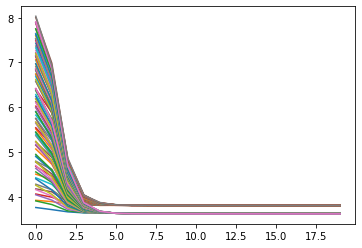

In [56]:
prediction = []
train_rmse = []
test_rmse = []
train_rmse_evo = []
test_rmse_evo = []
for i in range(1, 50):
    prediction, train_rmse, test_rmse = Gradient_descent(i,1,1,20,0.0001,I_train,I_test,train)
    train_rmse_evo.append(train_rmse[-1])
    test_rmse_evo.append(test_rmse[-1])

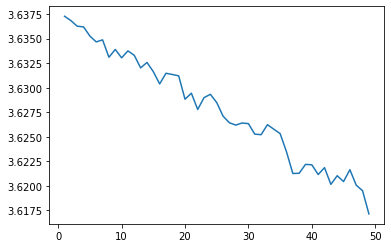

In [58]:
x = [i for i in range(1,50)]
argmin = np.argmin(train_rmse_evo)
plt.plot(x,train_rmse_evo)


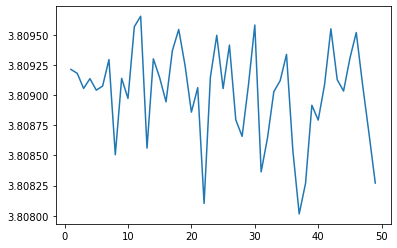

In [59]:
x = [i for i in range(1,50)]
argmin = np.argmin(test_rmse_evo)
plt.plot(x,test_rmse_evo)

## 6- Test PMF with different values of K (latent dimension)

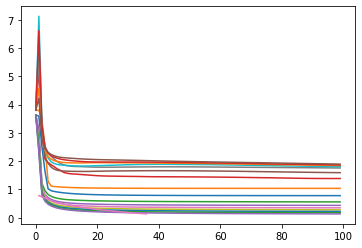

In [32]:

K = np.arange(1,40,5)
lambda_U = 0.1
lambda_V = 0.1
n_iter = 100
test_errors=[]
train_errors=[]
for k in K:
    prediction, train_rmse, test_rmse = PMF(n_iter,lambda_U, lambda_V, k)
    test_errors.append(test_rmse[-1])
    train_errors.append(train_rmse[-1])
plt.plot(K,train_errors)
plt.show()

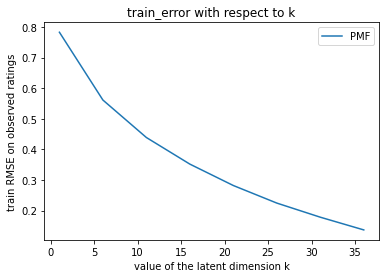

In [36]:
plt.plot(K,train_errors, label = 'PMF')
plt.xlabel('value of the latent dimension k')
plt.ylabel('train RMSE on observed ratings')
plt.title("train_error with respect to k")
plt.legend()
plt.show()


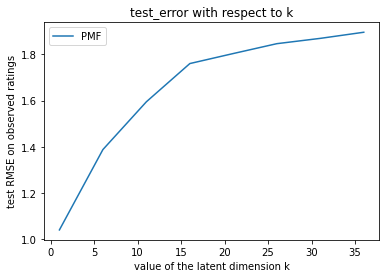

In [37]:
plt.plot(K,test_errors, label='PMF')
plt.xlabel('value of the latent dimension k')
plt.ylabel('test RMSE on observed ratings')
plt.title("test_error with respect to k")
plt.legend()
plt.show()

## 7- Test PMF for different regularization values

* Warning : Takes a lot of time to run*

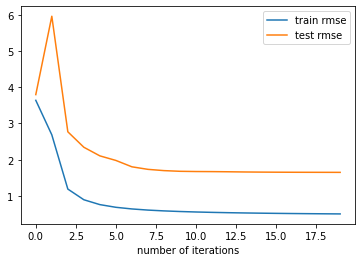

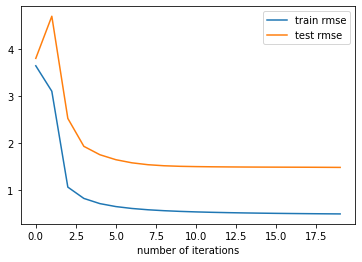

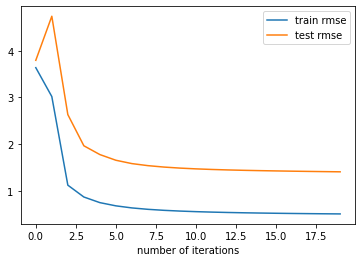

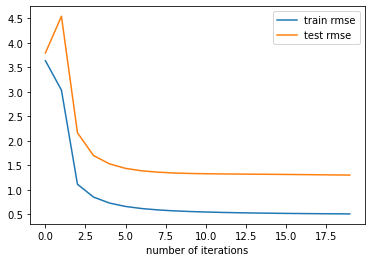

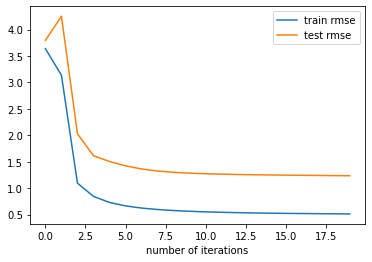

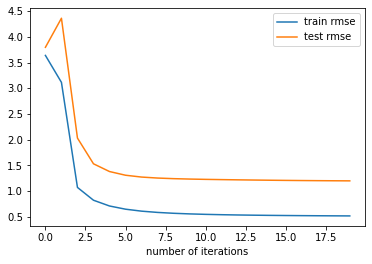

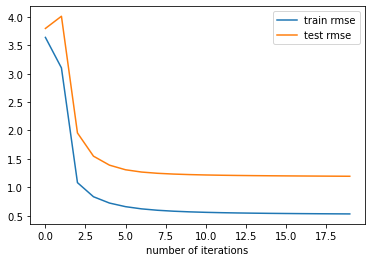

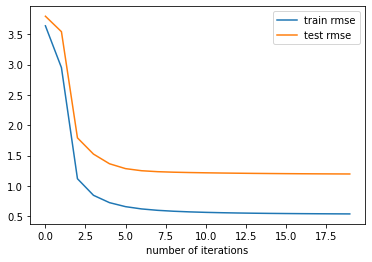

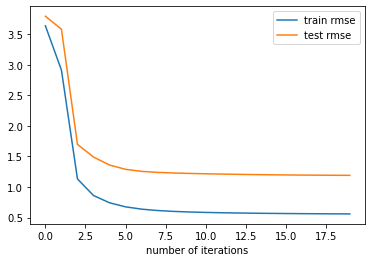

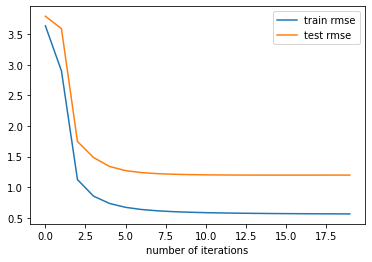

In [77]:
k = 10
K = np.arange(1,40,5)
lambdas= [0.1,0.5,1,5,10,20,30,50,80,100]
n_iter = 20
test_errors=[]
train_errors=[]
for lamda in lambdas:
    prediction, train_rmse, test_rmse = PMF(n_iter,lamda, lamda, k)
    test_errors.append(test_rmse[-1])
    train_errors.append(train_rmse[-1])


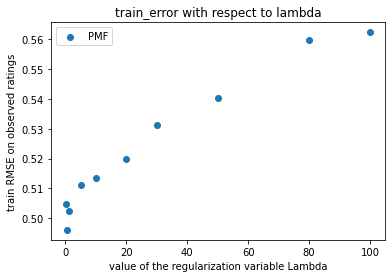

In [78]:
plt.scatter(lambdas,train_errors,label='PMF')
plt.xlabel('value of the regularization variable Lambda')
plt.ylabel('train RMSE on observed ratings')
plt.title("train_error with respect to lambda")
plt.legend()
plt.show()


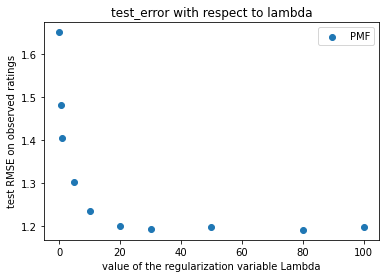

In [79]:
plt.scatter(lambdas,test_errors, label='PMF')
plt.xlabel('value of the regularization variable Lambda')
plt.ylabel('test RMSE on observed ratings')
plt.title("test_error with respect to lambda")
plt.legend()
plt.show()
plt.show()

## 8- Some hyperparameter testing experiments for ALS

    Without regularization

train_rmse 7.255746106528501
test_rmse 7.428233729901489
train_rmse 2.0869138595018435
test_rmse 3.2538823744026777
train_rmse 2.085639746128659
test_rmse 3.252521457150348
train_rmse 2.0852387202087463
test_rmse 3.252038854887803
train_rmse 2.0850245841590316
test_rmse 3.2519998529194787
train_rmse 2.0848407716617183
test_rmse 3.252163093765831
train_rmse 2.0847169184922736
test_rmse 3.2523799152679103
train_rmse 2.0846560975077613
test_rmse 3.2525685754368623
train_rmse 2.0846426156459708
test_rmse 3.2527015057156374
train_rmse 2.084659217972942
test_rmse 3.2527801754107304


(array([[ 3.40715522e+00,  9.02232828e-01,  9.40472146e-01, ...,
         -2.49864636e-02, -2.49864636e-02, -7.44422220e-02],
        [ 2.42798235e-01, -3.79216658e-02, -3.23450734e-02, ...,
          5.68021674e-03,  5.68021674e-03,  1.32472779e-02],
        [ 5.76744908e-03,  9.07103624e-03,  2.31486741e-02, ...,
         -1.85716842e-04, -1.85716842e-04, -2.50772522e-03],
        ...,
        [ 2.17420874e+00,  2.55617178e+00,  2.94799376e+00, ...,
         -1.32400999e-02, -1.32400999e-02, -7.11888609e-03],
        [ 3.09785996e-01,  4.00369037e-01,  2.23492418e-01, ...,
          2.24737673e-04,  2.24737673e-04,  3.35073914e-03],
        [ 5.72786099e+00, -3.12891198e-03, -2.83508546e-01, ...,
         -4.48600943e-04, -4.48600943e-04,  3.16921414e-02]]),
 [7.255746106528501,
  2.43136388222285,
  2.124029754880014,
  2.094672221744666,
  2.0886827496794775,
  2.0872526259399105,
  2.086963912989387,
  2.086952776604187,
  2.0869770119000464,
  2.0869687529778482,
  2.086913859501

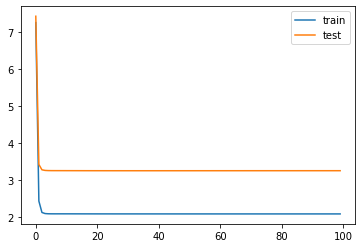

In [86]:

ALS(40,0,0,100) 

    With regularization

train_rmse 7.227637978335339
test_rmse 7.385105531473922
train_rmse 2.9285102714891984
test_rmse 3.469441831577322
train_rmse 2.9118208192532897
test_rmse 3.4641284262825707
train_rmse 2.9082603237032614
test_rmse 3.4637611453605386
train_rmse 2.90668508901122
test_rmse 3.4635819439247775
train_rmse 2.9057947091179157
test_rmse 3.4634529420750333
train_rmse 2.905329691913697
test_rmse 3.4633928762886588
train_rmse 2.9051250588917883
test_rmse 3.4633684961238416
train_rmse 2.905061038249164
test_rmse 3.463361086311457
train_rmse 2.905044061312482
test_rmse 3.4633591477240073


(array([[ 1.82439907e+00,  9.18479564e-01,  5.93437658e-01, ...,
         -3.84494228e-03, -3.84494228e-03, -6.68890447e-03],
        [ 8.56336600e-02,  3.97804915e-02, -1.86506770e-02, ...,
          1.04792927e-03,  1.04792927e-03,  2.88615700e-03],
        [ 1.61170561e-02,  8.16254070e-03,  7.92579372e-03, ...,
          4.09169523e-06,  4.09169523e-06, -3.24408637e-04],
        ...,
        [ 3.04498889e+00,  1.96162964e+00,  1.09004526e+00, ...,
         -1.03923985e-02, -1.03923985e-02,  5.08417035e-03],
        [ 2.32998303e-01,  1.72411015e-01,  8.91235645e-02, ...,
         -3.25134438e-04, -3.25134438e-04, -3.33605439e-04],
        [ 2.44838729e+00,  1.81515031e+00,  1.36579450e-01, ...,
          2.61251198e-02,  2.61251198e-02,  4.31165533e-02]]),
 [7.227637978335339,
  3.638160348554116,
  3.3906368072171693,
  3.101268481630611,
  3.032207583230603,
  2.9996253420583496,
  2.964935342748975,
  2.949235811266067,
  2.941082668315548,
  2.934130134854468,
  2.9285102714891

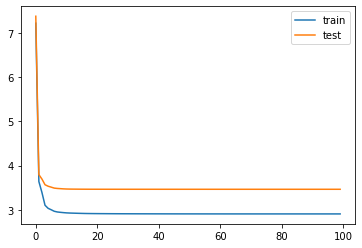

In [85]:
ALS(40,100,100,100)

In [30]:
def ALS(k,lamda,mu,niter):
    test_rmse = []
    train_rmse = []  
    U =  np.random.randn(610,k)
    V = np.random.randn(9724,k)

    for i in range(niter):
        prediction = np.dot(U,V.T)
        train_rmse = train_rmse + [np.linalg.norm(I_train*(train-prediction))/np.sqrt(np.sum(I_train))]
        test_rmse = test_rmse + [np.linalg.norm(I_test*(test-prediction))/np.sqrt(np.sum(I_test))]
        m1 = np.dot(V.T,V)+lamda*np.identity(k)
        solve_m1 = np.linalg.inv(m1)
        U = np.dot(train,np.dot(V,solve_m1))
        m2 = np.dot(U.T,U) + mu*np.identity(k)
        solve_m2 = np.linalg.inv(m2)
        V = np.dot(train.T,np.dot(U,solve_m2))
        #if i%10==0:
            #print('train_rmse',train_rmse[i])
            #print('test_rmse',test_rmse[i])
    return('train_rmse',train_rmse[-1],'test_rmse',test_rmse[-1])

In [88]:
d=40
for i in [0.01,0.1,1,10,20,50,80,100]:
    train_rmse_r, test_rmse_r=ALS(40,i,i,50)[1],ALS(40,i,i,50)[3]  
    train_rmse, test_rmse= ALS(40,0,0,50)[1],ALS(40,0,0,50)[3]
    if train_rmse_r<train_rmse:
        lambda_op=i
        print(i)
    else: 
        print("no regularization needed")

no regularization needed
no regularization needed
no regularization needed
no regularization needed
no regularization needed
no regularization needed
no regularization needed
no regularization needed


    we can see that the regularization can narrow the gap between our training and test MSE, but it does not decrease the test MSE

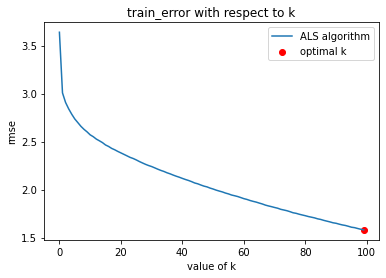

In [89]:
#experimentations on k-latent variable
#!!!!!!! comment plot lines in ALS function before executing this code
rmse=[]
nb=100
for i in range(nb):
    train_rmse=ALS(i,0.01,0.01,10)[1]
    rmse.append(train_rmse)
    if train_rmse == min(rmse):
        minr = train_rmse
        mink = i
        
plt.plot(range(nb),rmse,label='ALS algorithm')
plt.title("train_error with respect to k")
plt.xlabel('value of k')
plt.ylabel('rmse')
plt.scatter(mink,minr,color='red',label='optimal k')
plt.legend(loc="upper right")

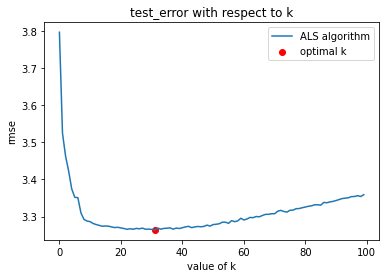

In [90]:
#experimentations on k-latent variable
#!!!!!!! comment plot lines in ALS function before executing this code
rmse=[]
nb=100
for i in range(nb):
    test_rmse=ALS(i,0.01,0.01,10)[3]
    rmse.append(test_rmse)
    if test_rmse == min(rmse):
        minr = test_rmse
        mink = i
        
plt.plot(range(nb),rmse,label='ALS algorithm')
plt.title("test_error with respect to k")
plt.xlabel('value of k')
plt.ylabel('rmse')
plt.scatter(mink,minr,color='red',label='optimal k')
plt.legend(loc="upper right")

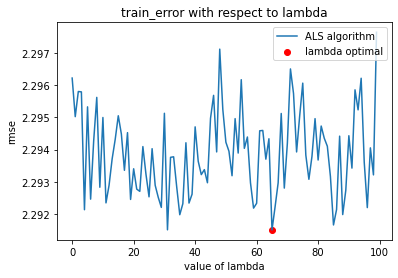

In [91]:
#experimentations on lambda (train data)
#!!!!!!! comment plot lines in ALS function before executing this code
rmse_l=[]
lamdas= range(100)
for lamda in lamdas:
    train_rmse_l=ALS(26,lamda,0.01,10)[1]
    rmse_l.append(train_rmse_l)
    if train_rmse_l == min(rmse_l):
        minr_l = train_rmse_l
        min_lamda = lamda
        
plt.plot(lamdas,rmse_l,label='ALS algorithm')
plt.title("train_error with respect to lambda")
plt.xlabel('value of lambda')
plt.ylabel('rmse')
plt.scatter(min_lamda,minr_l,color='red',label='lambda optimal')
plt.legend(loc="upper right")


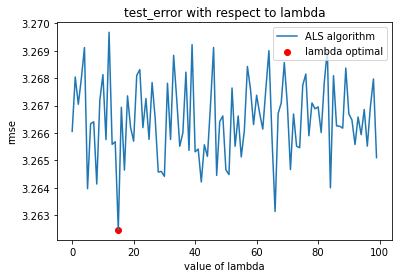

In [92]:
#experimentations on lambda (test data)
#!!!!!!! comment plot lines in ALS function before executing this code
rmse_l=[]
lamdas= range(100)
for lamda in lamdas:
    test_rmse_l=ALS(26,lamda,0.01,10)[3]
    rmse_l.append(test_rmse_l)
    if test_rmse_l == min(rmse_l):
        minr_l = test_rmse_l
        min_lamda = lamda
        
plt.plot(lamdas,rmse_l,label='ALS algorithm')
plt.title("test_error with respect to lambda")
plt.xlabel('value of lambda')
plt.ylabel('rmse')
plt.scatter(min_lamda,minr_l,color='red',label='lambda optimal')
plt.legend(loc="upper right")

## 9  Let's compare between PMF, GD AND ALS a larger dataset

The new dataset is this one : https://grouplens.org/datasets/movielens/1m/

In [35]:
### import the data and create matrix R
# data = pd.read_table('ratings.dat',sep='::',header=None)
# data.columns = ['userId','movieId','rating','time']
# data = data.astype({'userId':'int','movieId':'int'})
# data = data[['userId','movieId','rating']]
# R = data.pivot(index='userId', columns = 'movieId', values = 'rating')
# R = R.fillna(0)
# R = R.values

## 1- split to train test set 
def create_train_test(ratings):
    """
    split into training and test sets,
    remove 15 ratings from each user
    and assign them to the test set
    """
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_index = np.random.choice(
            np.flatnonzero(ratings[user]), size = 15, replace = False)
        train[user, test_index] = 0.0
        test[user, test_index] = ratings[user, test_index]
        
    # assert that training and testing set are truly disjoint
    assert np.all(train * test == 0)
    return train, test

train, test = create_train_test(R) ## split to train test
I_train = train!= 0 #mask for train set
I_test = test!= 0    ##mask for test set

In [36]:
R.shape

(6040, 3706)

In [37]:
100 * np.sum(I_test)/np.sum(I_train)

9.960323611573765

    We change the dimension in the above functions to adapt to the new dataset

In [43]:
def PMF(n_iter,lambda_U, labmda_V, n_dims):
    n_users = 6040
    n_movies = 3706
    log_aps = []
    train_rmse = []
    test_rmse = [] 
    U = np.zeros((n_dims, n_users), dtype=np.float64)
    V = np.random.normal(0.0, 1.0 / lambda_V, (n_dims, n_movies))
    
    for k in range(n_iter):
        prediction = np.dot(U.T,V)
        train_rmse = train_rmse + [np.linalg.norm(I_train*(train-prediction))/np.sqrt(np.sum(I_train))]
        test_rmse = test_rmse + [np.linalg.norm(I_test*(test-prediction))/np.sqrt(np.sum(I_test))]
        for i in range(n_users):
            V_j = V[:, train[i, :] > 0]
            U[:, i] = np.dot(np.linalg.inv(np.dot(V_j, V_j.T) + lambda_U * np.identity(n_dims)), np.dot(train[i, train[i, :] > 0], V_j.T))
        for j in range(n_movies):
            U_i = U[:, train[:, j] > 0]
            V[:, j] = np.dot(np.linalg.inv(np.dot(U_i, U_i.T) + lambda_V * np.identity(n_dims)), np.dot(train[train[:, j] > 0, j], U_i.T))
    plt.plot(train_rmse,label='train rmse')
    plt.plot(test_rmse,label='test rmse')
    plt.xlabel('number of iterations')
    plt.legend()
    plt.show()
    return prediction, train_rmse, test_rmse

In [42]:
def ALS(k,lamda,mu,niter):
    test_rmse = []
    train_rmse = []  
    U =  np.random.randn(6040,k)
    V = np.random.randn(3706,k)

    for i in range(niter):
        prediction = np.dot(U,V.T)
        train_rmse = train_rmse + [np.linalg.norm(I_train*(train-prediction))/np.sqrt(np.sum(I_train))]
        test_rmse = test_rmse + [np.linalg.norm(I_test*(test-prediction))/np.sqrt(np.sum(I_test))]
        m1 = np.dot(V.T,V)+lamda*np.identity(k)
        solve_m1 = np.linalg.inv(m1)
        U = np.dot(train,np.dot(V,solve_m1))
        m2 = np.dot(U.T,U) + mu*np.identity(k)
        solve_m2 = np.linalg.inv(m2)
        V = np.dot(train.T,np.dot(U,solve_m2))
        if i%10==0:
            print('train_rmse',train_rmse[i])
            print('test_rmse',test_rmse[i])

    plt.plot(train_rmse,label='train')
    plt.plot(test_rmse,label='test')
    plt.legend(loc="upper right")
    return(prediction, train_rmse, test_rmse)

In [41]:

## This function implements Gradient descent training and also returns the prediction,
#the list of train errors and the list of test errors for each time step
## It plots them too
def Gradient_descent(k,lamda,mu,niter,tau,I_train,I_test,train):
    test_rmse = []
    train_rmse = []  
    U =  np.random.randn(6040,k)
    V = np.random.randn(3706,k)

    for i in range(niter):
        prediction = np.dot(U,V.T)
        train_rmse = train_rmse + [np.linalg.norm(I_train*(train-prediction))/np.sqrt(np.sum(I_train))]
        test_rmse = test_rmse + [np.linalg.norm(I_test*(test-prediction))/np.sqrt(np.sum(I_test))]
        rmse = np.linalg.norm((train-prediction))
        U = U-tau*(np.dot(-2*train,V)+np.dot(2*U,np.dot(V.T,V))+2*lamda*U)

        V = V-tau*(np.dot(-2*train.T,U)+np.dot(2*V,np.dot(U.T,U))+2*mu*V)
#         if i%10==0:
#             print('train_rmse',train_rmse[i])
#             print('test_rmse',test_rmse[i])
    plt.plot(train_rmse)
    plt.plot(test_rmse)
    return(prediction, train_rmse, test_rmse)

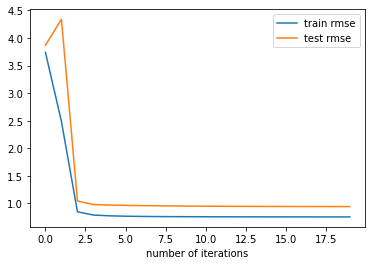

train_rmse 4.879834172801632
test_rmse 4.99486604540589
train_rmse 2.5854966438567626
test_rmse 3.1909004115595687


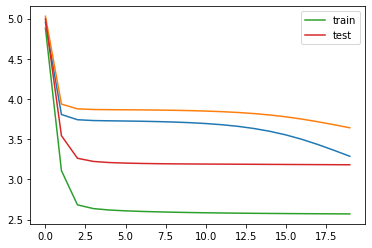

In [47]:

n_dims = 10 
lambda_U = 1
lambda_V = 1
n_iter = 20
k = 10
tau = 0.0001
lamda = 1
mu = 1
prediction_PMF, train_rmse_PMF , test_rmse_PMF = PMF(n_iter,lambda_U, lambda_V, n_dims)
prediction_GD, train_rmse_GD , test_rmse_GD = Gradient_descent(k,lamda,mu,n_iter,tau,I_train,I_test,train)
prediction_ALS, train_rmse_ALS , test_rmse_ALS = ALS(k,lamda,mu,n_iter)

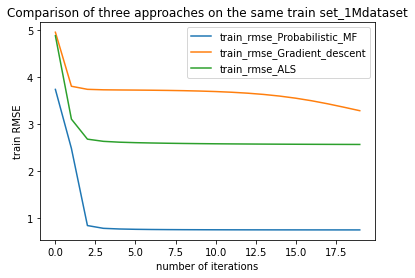

In [48]:
plt.plot(train_rmse_PMF, label = 'train_rmse_Probabilistic_MF')
plt.plot(train_rmse_GD, label = 'train_rmse_Gradient_descent')
plt.plot(train_rmse_ALS, label = 'train_rmse_ALS')
plt.xlabel('number of iterations')
plt.ylabel('train RMSE')
plt.legend()
plt.title('Comparison of three approaches on the same train set_1Mdataset')
plt.show()

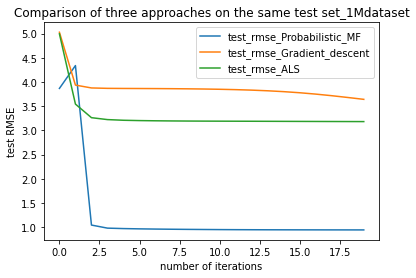

In [49]:
plt.plot(test_rmse_PMF, label = 'test_rmse_Probabilistic_MF')
plt.plot(test_rmse_GD, label = 'test_rmse_Gradient_descent')
plt.plot(test_rmse_ALS, label = 'test_rmse_ALS')
plt.xlabel('number of iterations')
plt.ylabel('test RMSE')
plt.legend()
plt.title('Comparison of three approaches on the same test set_1Mdataset')
plt.show()